In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-electronics-reviews/Electronics_5.json


In [3]:
import pandas as pd
import numpy as np
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:

df=pd.read_json('/kaggle/input/amazon-electronics-reviews/Electronics_5.json',lines=True,orient='columns')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,AO94DHGC771SJ,0528881469,amazdnu,"[0, 0]",We got this GPS for my husband who is an (OTR)...,5,Gotta have GPS!,1370131200,"06 2, 2013"
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1,Very Disappointed,1290643200,"11 25, 2010"
2,A3N7T0DY83Y4IG,0528881469,C. A. Freeman,"[43, 45]","Well, what can I say. I've had this unit in m...",3,1st impression,1283990400,"09 9, 2010"
3,A1H8PY3QHMQQA0,0528881469,"Dave M. Shaw ""mack dave""","[9, 10]","Not going to write a long review, even thought...",2,"Great grafics, POOR GPS",1290556800,"11 24, 2010"
4,A24EV6RXELQZ63,0528881469,Wayne Smith,"[0, 0]",I've had mine for a year and here's what we go...,1,"Major issues, only excuses for support",1317254400,"09 29, 2011"


In [5]:
df.shape

(1689188, 9)

In [6]:
df = df[['reviewerID', 'asin', 'overall']]
df = df.head(50000)

df.head()

,reviewerID,asin,overall
0,AO94DHGC771SJ,0528881469,5
1,AMO214LNFCEI4,0528881469,1
2,A3N7T0DY83Y4IG,0528881469,3
3,A1H8PY3QHMQQA0,0528881469,2
4,A24EV6RXELQZ63,0528881469,1


In [7]:
df.shape

(50000, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reviewerID  50000 non-null  object
 1   asin        50000 non-null  object
 2   overall     50000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [9]:
df.dtypes

reviewerID    object
asin          object
overall        int64
dtype: object

In [10]:
df.overall.describe()

count    50000.000000
mean         4.282560
std          1.140906
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [11]:
df.overall.describe().transpose()

count    50000.000000
mean         4.282560
std          1.140906
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [12]:
print('The Minimum and Maximum values of Overall column : ',(df.overall.min(),df.overall.max()))

The Minimum and Maximum values of Overall column :  (1, 5)


In [13]:
df.isna().sum()

reviewerID    0
asin          0
overall       0
dtype: int64

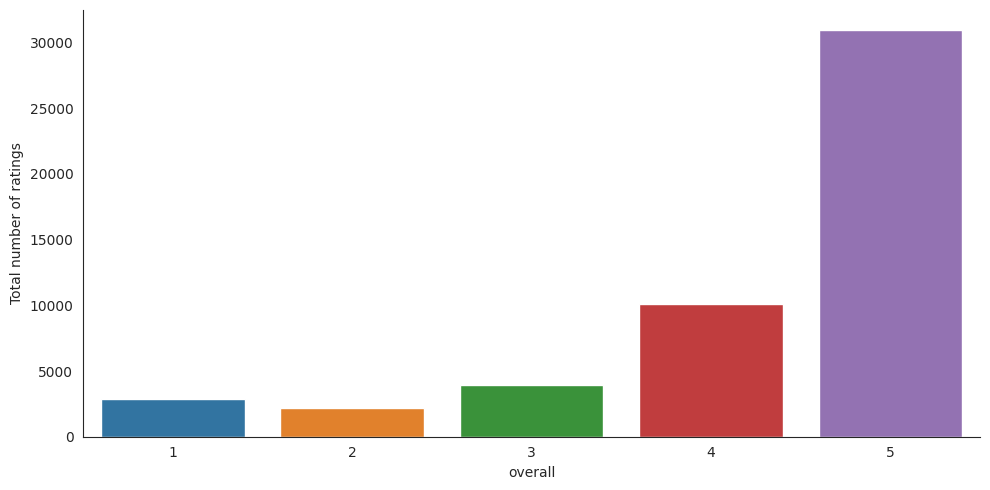

In [14]:
with sns.axes_style('white'):
    g = sns.catplot(x="overall", data=df, aspect=2.0, kind='count')
    g.set_ylabels("Total number of ratings")


In [15]:
print('Unique number of users in the data : ', df.reviewerID.nunique())
print('Unique number of products in the data : ', df.asin.nunique())

Unique number of users in the data :  36074
Unique number of products in the data :  2020


In [16]:
most_rated = df.groupby('reviewerID').size().sort_values(ascending=False)[:15]
print('Top 10 user based on ratings : ', most_rated)

Top 10 user based on ratings :  reviewerID
A231WM2Z2JL0U3    121
A5JLAU2ARJ0BO      64
AT2J7H5TRZM8Z      36
A1MJMYLRTZ76ZX     34
A6FIAB28IS79       30
A2R6RA8FRBS608     25
A2VV0TJNJT9D3O     24
A2AEZQ3DGBBLPR     22
A1RPTVW5VEOSI      22
A1NVD0TKNS1GT5     21
A2BGZ52M908MJY     21
A1JJOV69MAU2J2     20
A2G2QNKDL1Y6AC     19
ARXU3FESTWMJJ      19
A1522TN5FVJL0Y     19
dtype: int64


In [17]:
# counting the uniques values of each product...
counts = df.reviewerID.value_counts()
# taking the data with which have the count > 15 of unique ratings
df_final = df[df.reviewerID.isin(counts[counts>15].index)]
print('Number of users who have rated 25 or more products : ',len(df_final))
print('Number of unique user in the final data : ', df_final.reviewerID.nunique())
print('Number of uniques products in the final data : ', df_final.asin.nunique())

Number of users who have rated 25 or more products :  685
Number of unique user in the final data :  26
Number of uniques products in the final data :  474


In [18]:
final_rating_matrix = df_final.pivot(index='reviewerID',columns='asin',values='overall').fillna(0)
final_rating_matrix.head()

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RSK5,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1522TN5FVJL0Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1JJOV69MAU2J2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
final_rating_matrix.shape

(26, 474)

In [20]:
given_number_of_ratings = np.count_nonzero(final_rating_matrix)
print("Number of ratings : ", given_number_of_ratings)

possible_number_of_ratings = final_rating_matrix.shape[0]*final_rating_matrix.shape[1]
print("Possible number of ratings : ",possible_number_of_ratings)

density = (given_number_of_ratings/possible_number_of_ratings)
density *= 100
print("Density : ",density)


Number of ratings :  685
Possible number of ratings :  12324
Density :  5.558260305095748


In [21]:
train_data, test_data = train_test_split(df_final, test_size=0.3, random_state = 0)
train_data.head()

,reviewerID,asin,overall
28756,A2AEZQ3DGBBLPR,B000063S4I,5
12066,A231WM2Z2JL0U3,B00004Y2MM,5
20344,A3L60UJZQ0O0R5,B00005B8HO,5
11699,A2BGZ52M908MJY,B00004X0ZI,2
20149,A1MJMYLRTZ76ZX,B00005AWCL,3


In [22]:
print("Training data : ",train_data.shape)
print("Testing data : ", test_data.shape)

Training data :  (479, 3)
Testing data :  (206, 3)


In [23]:
train_data_grouped = train_data.groupby('asin').agg({'reviewerID' : 'count'}).reset_index()
train_data_grouped.rename(columns = {'reviewerID': 'score'},inplace=True)
train_data_grouped.head(30)

,asin,score
0,1400532655,1
1,B00000IGBF,1
2,B00000J05A,1
3,B00000J061,1
4,B00000J08C,1
5,B00000J1E6,1
6,B00000J1TX,1
7,B00000J3II,1
8,B00000J3Q1,1
9,B00000J434,1


In [24]:
train_data_sort = train_data_grouped.sort_values(['score','asin'], ascending = [0,1])

train_data_rank = train_data_sort['score'].rank(ascending=0, method='first')

popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,asin,score
342,B00006JKXN,6
61,B00004SB92,5
95,B00004VWM3,5
40,B000031KIM,4
216,B00005QFZG,4


In [25]:
def recommend(user_id):
    user_recommendations = popularity_recommendations
    
    user_recommendations['reviewerID'] = user_id
    
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]
    return user_recommendations

In [26]:
users = [5,34,23]

for i in users:
    print("USer : ",i)
    print(recommend(i))
    print()

USer :  5
     reviewerID        asin  score
342           5  B00006JKXN      6
61            5  B00004SB92      5
95            5  B00004VWM3      5
40            5  B000031KIM      4
216           5  B00005QFZG      4

USer :  34
     reviewerID        asin  score
342          34  B00006JKXN      6
61           34  B00004SB92      5
95           34  B00004VWM3      5
40           34  B000031KIM      4
216          34  B00005QFZG      4

USer :  23
     reviewerID        asin  score
342          23  B00006JKXN      6
61           23  B00004SB92      5
95           23  B00004VWM3      5
40           23  B000031KIM      4
216          23  B00005QFZG      4



In [27]:
len(list(train_data_sort.asin))   # number of products

365

In [28]:
collaborative_filter_df = pd.concat([train_data, test_data]).reset_index()
collaborative_filter_df.head()

,index,reviewerID,asin,overall
0,28756,A2AEZQ3DGBBLPR,B000063S4I,5
1,12066,A231WM2Z2JL0U3,B00004Y2MM,5
2,20344,A3L60UJZQ0O0R5,B00005B8HO,5
3,11699,A2BGZ52M908MJY,B00004X0ZI,2
4,20149,A1MJMYLRTZ76ZX,B00005AWCL,3


In [29]:
pivot_df = collaborative_filter_df.pivot(index='reviewerID', columns = 'asin', values='overall').fillna(0)
pivot_df

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RSK5,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1522TN5FVJL0Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1JJOV69MAU2J2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A231WM2Z2JL0U3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A242IFN64X6R4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0
A25HBO5V8S8SEA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2AEZQ3DGBBLPR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


In [30]:
pivot_df.shape

(26, 474)

In [31]:
pivot_df['user_index'] = np.arange(0,pivot_df.shape[0],1)
pivot_df.head()

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU,user_index
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1522TN5FVJL0Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A1JJOV69MAU2J2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,2
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [32]:
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head()

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RSK5,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
U,sigma, Vt = svds(pivot_df, k=10)

In [34]:
print('Sinular Matrix',U)

Sinular Matrix [[ 3.93452514e-01  1.18733665e-01 -1.38062300e-01 -1.23475289e-01
  -3.95185397e-03  1.11303714e-01  1.34024288e-01 -4.73906507e-02
  -1.28606595e-01  6.44936576e-02]
 [ 8.82348365e-02  1.85554925e-01 -4.93774961e-02  1.24343989e-01
  -7.18973158e-02  3.92028507e-02  2.35392617e-02  2.80885879e-01
  -1.16169116e-03  2.85971983e-02]
 [-9.09661701e-02 -2.07455197e-01 -5.29694083e-02 -4.18929390e-02
   1.71946707e-01 -4.66055787e-02  3.97103250e-01  7.92660263e-01
  -2.35088610e-02  4.97737174e-02]
 [-3.73188455e-01  2.78512649e-01 -6.39856386e-02 -1.35510183e-03
  -3.54538876e-01 -7.15322202e-02 -7.52510612e-02  4.23806157e-02
  -5.08891468e-02  4.01696924e-02]
 [ 1.82721600e-01 -4.21440495e-01  4.82196046e-02  3.16762244e-02
  -5.58802018e-01 -8.55938162e-02 -1.91004849e-01  6.63854194e-02
  -3.84166335e-02  2.88809482e-02]
 [-1.13755480e-02 -4.35841385e-02 -4.89780027e-02 -5.08361879e-03
   3.91625423e-02 -3.26446492e-02  8.93585200e-02 -1.15205959e-01
   2.19302519e-01 

In [35]:
print('Sigma : ',sigma)

Sigma :  [21.25548393 21.28446065 21.80759907 22.9776357  23.59365708 24.36766988
 24.98942989 30.13398789 35.20472105 51.50602223]


In [36]:
sigma= np.diag(sigma)
print("Diagonal matrix : ",sigma)

Diagonal matrix :  [[21.25548393  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         21.28446065  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         21.80759907  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         22.9776357   0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         23.59365708  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         24.36766988
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  24.98942989  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         30.13398789  0.          0.        ]
 [ 0.          0.          0.        

In [37]:
print('Singular Matrix : ',Vt)

Singular Matrix :  [[-0.00123534 -0.02377311  0.00969559 ... -0.02386897  0.13138545
   0.01297573]
 [-0.00031657 -0.00902956 -0.00885371 ... -0.0493671   0.08074619
   0.01367558]
 [-0.00036201  0.0115014   0.01724801 ... -0.01286873 -0.01608697
   0.00114342]
 ...
 [-0.00284603 -0.00115254  0.01687543 ...  0.12583058  0.00556071
   0.00169436]
 [-0.02712568 -0.00394631 -0.00080768 ... -0.05759024 -0.00205229
  -0.00066366]
 [ 0.00360001  0.00123656  0.00153332 ...  0.01203185  0.00256501
   0.00120119]]


In [38]:
all_user_predictions = np.dot(np.dot(U, sigma), Vt)
preds_df = pd.DataFrame(all_user_predictions, columns = pivot_df.columns)
preds_df.head()

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RSK5,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU
0,0.128746,0.406813,-0.016376,-0.195256,-0.089881,0.166800,1.379643,-0.000305,0.406813,-0.508108,...,0.643729,0.643729,0.297212,0.643729,0.138251,0.642205,0.332298,0.097924,1.379643,0.297212
1,-0.020081,-0.136092,0.077616,0.430837,-0.043391,0.462361,0.676492,-0.032368,-0.136092,-0.214557,...,-0.100407,-0.100407,0.099143,-0.100407,1.225620,-0.262248,0.911453,0.810544,0.676492,0.099143
2,0.010370,0.041616,0.373711,-0.046674,-0.230273,0.342411,-0.514463,0.020324,0.041616,0.502291,...,0.051852,0.051852,-0.140462,0.051852,4.015150,0.153470,-0.360274,4.403953,-0.514463,-0.140462
3,0.046925,0.155152,-0.151273,-0.047044,0.179236,0.361745,-0.305973,-0.058519,0.155152,0.162509,...,0.234627,0.234627,-0.105439,0.234627,0.060265,-0.057971,-0.400486,-0.261682,-0.305973,-0.105439
4,0.004957,0.036538,0.139478,-0.114120,2.885568,0.045989,0.122263,0.061896,0.036538,0.474980,...,0.024783,0.024783,-0.169354,0.024783,0.371020,0.334262,-0.193759,-0.220360,0.122263,-0.169354


In [42]:
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    user_idx = userID-1
    
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [43]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)  


Below are the recommended items for user(user_id = 4):

                   user_ratings  user_predictions
Recommended Items                                
B00004TEN2                  0.0          2.677237
B00004WCIA                  0.0          2.042094
B000053HH5                  0.0          2.025367
B00003G1RG                  0.0          1.999441
B00006JKXN                  0.0          1.983237


In [44]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   user_ratings  user_predictions
Recommended Items                                
B00000JSGF                  0.0          0.951749
B00006FDR8                  0.0          0.942381
B00005ARK3                  0.0          0.905869
B00006B9Q7                  0.0          0.900805
B00006I5O1                  0.0          0.896579


In [45]:
final_rating_matrix.head()

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RSK5,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU
reviewerID,,,,,,,,,,,,,,,,,,,,,
A1522TN5FVJL0Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1JJOV69MAU2J2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1MJMYLRTZ76ZX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
A1NVD0TKNS1GT5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1RPTVW5VEOSI,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
final_rating_matrix.mean().head()

asin
1400532655    0.038462
B000001OL6    0.153846
B00000IGBF    0.153846
B00000J05A    0.115385
B00000J061    0.192308
dtype: float64

In [47]:
preds_df.head()

asin,1400532655,B000001OL6,B00000IGBF,B00000J05A,B00000J061,B00000J08C,B00000J0D5,B00000J1E6,B00000J1EP,B00000J1TX,...,B00006RSK5,B00006RU4L,B00006RVNH,B00006RYUX,B000071A7U,B000071NY3,B000075UZ7,B00007B6L5,B00007BI0H,B00007E7JU
0,0.128746,0.406813,-0.016376,-0.195256,-0.089881,0.166800,1.379643,-0.000305,0.406813,-0.508108,...,0.643729,0.643729,0.297212,0.643729,0.138251,0.642205,0.332298,0.097924,1.379643,0.297212
1,-0.020081,-0.136092,0.077616,0.430837,-0.043391,0.462361,0.676492,-0.032368,-0.136092,-0.214557,...,-0.100407,-0.100407,0.099143,-0.100407,1.225620,-0.262248,0.911453,0.810544,0.676492,0.099143
2,0.010370,0.041616,0.373711,-0.046674,-0.230273,0.342411,-0.514463,0.020324,0.041616,0.502291,...,0.051852,0.051852,-0.140462,0.051852,4.015150,0.153470,-0.360274,4.403953,-0.514463,-0.140462
3,0.046925,0.155152,-0.151273,-0.047044,0.179236,0.361745,-0.305973,-0.058519,0.155152,0.162509,...,0.234627,0.234627,-0.105439,0.234627,0.060265,-0.057971,-0.400486,-0.261682,-0.305973,-0.105439
4,0.004957,0.036538,0.139478,-0.114120,2.885568,0.045989,0.122263,0.061896,0.036538,0.474980,...,0.024783,0.024783,-0.169354,0.024783,0.371020,0.334262,-0.193759,-0.220360,0.122263,-0.169354


In [48]:
preds_df.mean().head()

asin
1400532655    0.046652
B000001OL6    0.216834
B00000IGBF    0.060069
B00000J05A    0.114566
B00000J061    0.237662
dtype: float64

In [50]:
rmse_df = pd.concat([final_rating_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(474, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
asin,,,
1400532655,0.038462,0.046652,0
B000001OL6,0.153846,0.216834,1
B00000IGBF,0.153846,0.060069,2
B00000J05A,0.115385,0.114566,3
B00000J061,0.192308,0.237662,4


In [51]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.08493 



In [52]:
# Save the SVD model
model_filename = 'svd_model.joblib'
dump((U, sigma, Vt), model_filename)

# Save the pivot_df for later use (optional)
pivot_df_filename = 'pivot_df.joblib'
dump(pivot_df, pivot_df_filename)

# Save the preds_df for later use (optional)
preds_df_filename = 'preds_df.joblib'
dump(preds_df, preds_df_filename)


['preds_df.joblib']

In [53]:
# Load the SVD model
loaded_U, loaded_sigma, loaded_Vt = load(model_filename)

# Load the pivot_df (optional)
loaded_pivot_df = load(pivot_df_filename)

# Load the preds_df (optional)
loaded_preds_df = load(preds_df_filename)
